In [18]:
# Importing the required libraries

import os
from os import listdir
import random
import shutil
from utils import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
uninfected = 'D:/archive/cell_images/Uninfected'
parasitized = 'D:/archive/cell_images/Parasitized'

# Create list to store the image path and label

data = []
label = []

for filename in os.listdir(parasitized):
  if filename.endswith('.png'):
    filepath = os.path.join(parasitized, filename)
    data.append(filepath)
    label.append(1)  # Label 1 for affected cells

for filename in os.listdir(uninfected):
  if filename.endswith('.png'):
    filepath = os.path.join(uninfected, filename)
    data.append(filepath)
    label.append(0)  # Label 0 for unaffected cells
np.random.shuffle(data)
'''
resized_images = []
img_size = [224,224]
for img_path in data:
  img = cv2.imread(img_path)
  img = cv2.resize(img, img_size)  # Resize the image
  resized_images.append(img)
'''
# Split data into training, validation, and test sets
train_images, test_images, train_labels, test_labels = train_test_split(data, label, test_size=0.2, random_state=42)
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2 for validation

# Print the lengths of each set for verification
print(f"Training set: {len(train_images)} samples")
print(f"Validation set: {len(val_images)} samples")
print(f"Test set: {len(test_images)} samples")



# Split the data into training and test sets (80% training, 20% test)
#train_data, test_data, train_labels, test_labels = train_test_split(data,
#                                                                    label,
#                                                                    test_size=0.2,
#                                                                    random_state=42)


Training set: 16534 samples
Validation set: 5512 samples
Test set: 5512 samples


In [9]:
print(train_images[2])

D:/archive/cell_images/Parasitized\C59P20thinF_IMG_20150803_113809_cell_41.png


In [10]:
def move_images_to_directory(image_list, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Move images to the destination folder
    for image_path in image_list:
        filename = os.path.basename(image_path)
        destination_path = os.path.join(destination_folder, filename)
        shutil.copy(image_path, destination_path)

# Replace 'path/to/' with your desired directory paths
train_folder = 'D:/archive/cell_images/train/train1'
val_folder = 'D:/archive/cell_images/val/val1'
test_folder = 'D:/archive/cell_images/test/test1'

# Move images to their respective directories
move_images_to_directory(train_images, train_folder)
move_images_to_directory(val_images, val_folder)
move_images_to_directory(test_images, test_folder)

In [11]:
train_rescale = ImageDataGenerator(rescale=1./255)  # Normalize pixel values
val_rescale = ImageDataGenerator(rescale=1./255)

train_generator = train_rescale.flow_from_directory(
    'D:/archive/cell_images/train',
    target_size=(224, 224),  # Resize images to fit ResNet50 input size
    batch_size=32,
    class_mode='binary'  # Adjust for your problem's class mode
)

val_generator = val_rescale.flow_from_directory(
    'D:/archive/cell_images/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary' 
)

Found 16534 images belonging to 1 classes.
Found 5512 images belonging to 1 classes.


In [12]:
resnet_model = ResNet50(weights='imagenet', include_top=False)  # Load pre-trained ResNet50 without the fully connected layers

x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(100, activation='relu')(x)  # Add your own dense layers for classification
predictions = Dense(1, activation='sigmoid')(x)

model_resnet = Model(inputs=resnet_model.input, outputs=predictions)

# Freeze pre-trained layers
for layer in resnet_model.layers:
    layer.trainable = False

model_resnet.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])  # Adjust loss and metrics



94765736/94765736 [==============================] - 13s 0us/step


In [13]:
train_resnet = model_resnet.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=2,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/2


517/517 [==============================] - 1597s 3s/step - loss: 0.0041 - accuracy: 0.9981 - val_loss: 8.5129e-09 - val_accuracy: 1.0000
Epoch 2/2
517/517 [==============================] - 1557s 3s/step - loss: 3.8075e-09 - accuracy: 1.0000 - val_loss: 1.7429e-09 - val_accuracy: 1.0000


In [14]:
test_rescale = ImageDataGenerator(rescale=1./255)
test_generator = test_rescale.flow_from_directory(
    'D:/archive/cell_images/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Evaluate the model on the test set
loss, accuracy = model_resnet.evaluate(test_generator)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

Found 5512 images belonging to 1 classes.
173/173 [==============================] - 400s 2s/step - loss: 1.7300e-09 - accuracy: 1.0000
Test Loss: 1.729973275743646e-09
Test Accuracy: 1.0


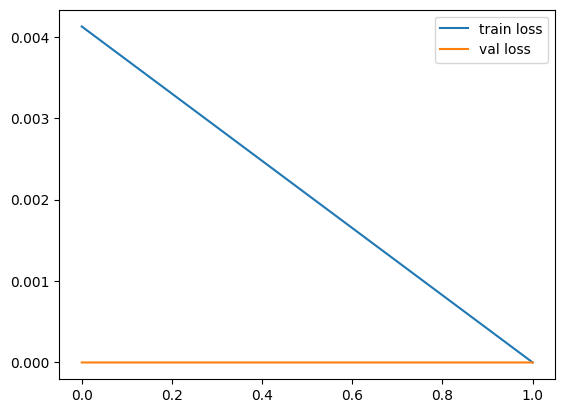

In [15]:
# plot the loss
plt.plot(train_resnet.history['loss'], label='train loss')
plt.plot(train_resnet.history['val_loss'], label='val loss')
plt.legend()
plt.show()
#plt.savefig('LossVal_loss')

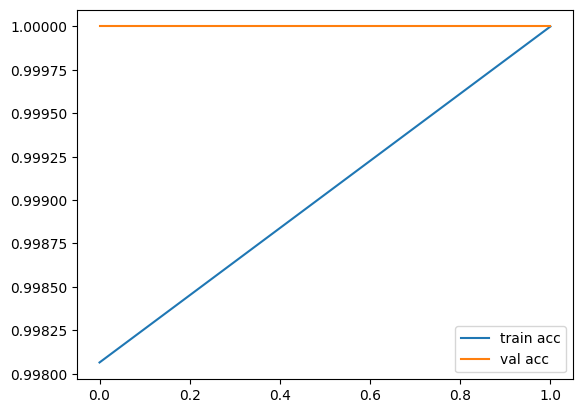

In [16]:
# plot the accuracy
plt.plot(train_resnet.history['accuracy'], label='train acc')
plt.plot(train_resnet.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [19]:
# save this model as h5 file

model_resnet.save('resnet_model.h5')

C:\Users\Win 10 Pro\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
y_pred = model_resnet.predict(test_generator)
y_pred

173/173 [==============================] - 386s 2s/step


array([[9.9050035e-10],
       [3.1402654e-09],
       [2.0102453e-09],
       ...,
       [1.8177547e-09],
       [2.3440190e-09],
       [1.3457179e-09]], dtype=float32)

In [50]:
y_pred = np.argmax(y_pred)
y_pred

0

In [51]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [52]:
model_res=load_model('resnet_model.h5')

In [53]:
sample_img=image.load_img('D:/archive/cell_images/Uninfected/C99P60ThinF_IMG_20150918_141001_cell_60.png',target_size=(224,224))
x=image.img_to_array(sample_img)
x

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [54]:
x = x/255

In [55]:
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [56]:
model_res.predict(img_data)

1/1 [==============================] - 2s 2s/step


array([[4.607309e-07]], dtype=float32)

In [57]:
a=np.argmax(model_res.predict(img_data), axis=1)

1/1 [==============================] - 0s 159ms/step


In [58]:
if(a==1):
    print("Infected")
else:
    print("Uninfected")

Uninfected
